In [91]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from algorithm import *
from entity import CW_Func_Handler, CW_Source, Three_Elements_Array, Snapshot_Generator
from utils import *

## 仿真实验


### 声场仿真

几何模型:
- 以三元阵中心为原点, 其中阵元1在x轴负半轴
- 声源S角度为角度制下极坐标角度

运动模型:
- 声源S静止
- 三元阵以相对于三元阵初始坐标轴的速度运动

In [92]:
fc = 37500  # 声源频率
sample_interval = 1  # 采样时长
fs = 8 * fc  # 倍频采样频率
# fs = 500000  # 500k采样率

vel_angle = 90
speed = 1
r = 1000
angle = 50

velocity = deg_pol2cart(speed, vel_angle)

target_sig = CW_Func_Handler(
    f=fc,  # 声源频率
    T=1,  # Cw信号周期
    T_on=10e-3,  # Cw信号脉宽
)
snapshot_generator = Snapshot_Generator(
    CW_Source(
    signal_func_callback=target_sig,
    r=r,  # 声源距离
    angle=angle,  # 声源角度
    seed=1,
),
    Three_Elements_Array(
        d=0.5,
        K=2,
        # seed=1000
    ),
    c=1500  # 声速
)

# snapshot_generator.set_SNR(30)
# snapshot_generator.set_SNR(20)
# snapshot_generator.set_SNR(10)
snapshot_generator.set_SNR(0)
# snapshot_generator.set_SNR(-5)
# snapshot_generator.set_SNR(-10)
# snapshot_generator.set_SNR(-15)
# snapshot_generator.set_SNR(-20)

# snapshot_generator.set_ideal()

#### 生成各阵元电信号AD采样后信号

In [93]:
t = np.arange(0, sample_interval, 1 / fs)
x, r_real, angle_real = snapshot_generator(t, velocity)

##### 信号图像

In [94]:
# tf_plot(x[0], fs)
# rfft_plot(x[0], fs, fc=37.5e3, bandwidth=2e3)

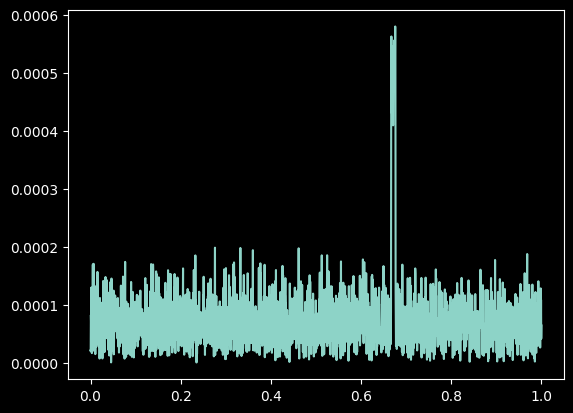

In [95]:
f, t1, Zxx = signal.stft(x[0], fs)
plt.plot(t1, np.abs(Zxx[np.argmin(np.abs(f-target_sig.f)),:]))
plt.show()

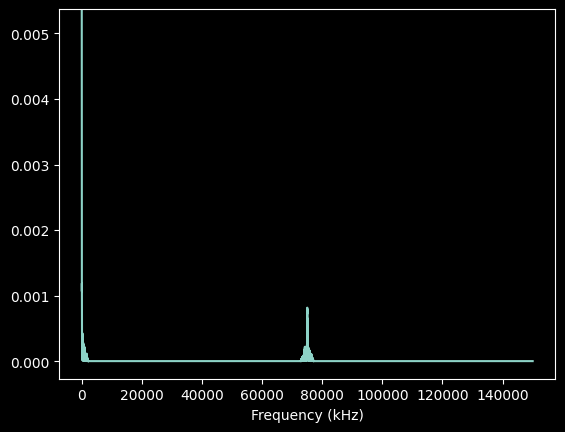

In [96]:
sos = signal.butter(20, (target_sig.f - 1000, target_sig.f + 1000), 'bandpass', fs=fs, output='sos')
pow_num = 2
x_filtered = [signal.sosfilt(sos, x_i)**pow_num for x_i in x]
rfft_plot(x_filtered[0], fs, fc=37.5e3)

### 定位

#### 时延估计

In [97]:
x = x_filtered
tau12_hat = time_delay_estimation(x[0], x[1], target_sig.f, fs, 'xcorr')
tau23_hat = time_delay_estimation(x[1], x[2], target_sig.f, fs, 'xcorr')

#### 解算方位

In [98]:
r_far, angle_far = far_locate(tau12_hat, tau23_hat, snapshot_generator.c, snapshot_generator.array.K, snapshot_generator.array.d)
# r_near, angle_near = near_locate(tau12_hat, tau23_hat, snapshot_generator.c, snapshot_generator.array.K, snapshot_generator.array.d)

In [99]:
analysis(snapshot_generator, tau12_hat, tau23_hat, r_far, angle_far, vel_angle)

,angle,tau12,tau23,r
real,50.000000,0.000214,0.000428,1000.000000
estimation,46.895326,0.000187,0.000497,-2.161036
abs_error,-3.104674,-0.000028,0.000068,-1002.161036
rel_error,0.077617,-0.129192,0.159279,-1.002161
